# Grammatical Acceptability Classification by Fine-tuning ConvBERT #

In this exercise, we will fine-tune a ConvBERT model to classify sentences based on their grammatical acceptability using the CoLA (Corpus of Linguistic Acceptability) dataset. The goal is to determine whether a given sentence is grammatically correct (acceptable) or incorrect (unacceptable). The successful implementation of this AI model will greatly enhance the Student Help Centre’s ability to provide valuable, timely assistance to students.



## Section 1: Install and import Required Libraries

In [1]:
!pip install torch transformers datasets

import torch
from torch.utils.data import DataLoader
from transformers import ConvBertTokenizer, ConvBertForSequenceClassification, AdamW
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pad_sequence


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00


## Section 2: Data Preparation

In [2]:
# Load CoLA dataset from Hugging Face datasets
dataset = load_dataset("glue", "cola")
train_dataset = dataset['train']
test_dataset = dataset['validation']

# Load ConvBERT Tokenizer
model_name = "YituTech/conv-bert-base"  # Publicly available ConvBERT model from Hugging Face
tokenizer = ConvBertTokenizer.from_pretrained(model_name)

# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['sentence'], padding=True, truncation=True)

train_dataset = train_dataset.map(lambda x: tokenize(x), batched=True)
test_dataset = test_dataset.map(lambda x: tokenize(x), batched=True)

# Convert dataset to PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/251k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

vocab.txt:   0%|          | 0.00/267k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

## Section 3: Model Setup and Fine-tuning

In [3]:
# Custom Collate Function for Sentence Padding

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True)
    labels = torch.tensor(labels)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'label': labels
    }

# Load Pre-trained ConvBERT model from Hugging Face in PyTorch
model = ConvBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Setup the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Prepare DataLoader with the custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Fine-tuning on the CoLA dataset
model.train()
for epoch in range(3):  # train for 3 epochs
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


pytorch_model.bin:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of ConvBertForSequenceClassification were not initialized from the model checkpoint at YituTech/conv-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.4323
Epoch 2, Loss: 0.2406
Epoch 3, Loss: 0.1551



## Section 4: Evaluate the Model

In [4]:
# Model Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8140


In [5]:
import torch
from torch.utils.data import DataLoader
from transformers import ConvBertTokenizer, ConvBertForSequenceClassification, BertTokenizer, BertForSequenceClassification, AdamW
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pad_sequence
import time

# Load CoLA dataset from Hugging Face datasets
dataset = load_dataset("glue", "cola")
train_dataset = dataset['train']
test_dataset = dataset['validation']

# Load Tokenizers
convbert_tokenizer = ConvBertTokenizer.from_pretrained("YituTech/conv-bert-base")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize(batch, tokenizer):
    return tokenizer(batch['sentence'], padding=True, truncation=True)

# Tokenize datasets for both models
train_dataset_convbert = train_dataset.map(lambda x: tokenize(x, convbert_tokenizer), batched=True)
test_dataset_convbert = test_dataset.map(lambda x: tokenize(x, convbert_tokenizer), batched=True)

train_dataset_bert = train_dataset.map(lambda x: tokenize(x, bert_tokenizer), batched=True)
test_dataset_bert = test_dataset.map(lambda x: tokenize(x, bert_tokenizer), batched=True)

# Convert datasets to PyTorch tensors
def format_for_torch(dataset):
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return dataset

train_dataset_convbert = format_for_torch(train_dataset_convbert)
test_dataset_convbert = format_for_torch(test_dataset_convbert)

train_dataset_bert = format_for_torch(train_dataset_bert)
test_dataset_bert = format_for_torch(test_dataset_bert)

# Custom collate function for sentence padding
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True)
    labels = torch.tensor(labels)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'label': labels
    }

# Prepare DataLoader for both models
train_dataloader_convbert = DataLoader(train_dataset_convbert, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader_convbert = DataLoader(test_dataset_convbert, batch_size=8, collate_fn=collate_fn)

train_dataloader_bert = DataLoader(train_dataset_bert, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader_bert = DataLoader(test_dataset_bert, batch_size=8, collate_fn=collate_fn)

# Load Pre-trained ConvBERT and BERT models
convbert_model = ConvBertForSequenceClassification.from_pretrained("YituTech/conv-bert-base", num_labels=2)
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Setup optimizer
optimizer_convbert = AdamW(convbert_model.parameters(), lr=5e-5)
optimizer_bert = AdamW(bert_model.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
convbert_model.to(device)
bert_model.to(device)

# Function to fine-tune a model
def fine_tune_model(model, optimizer, train_dataloader, epochs=3):
    model.train()
    total_time = 0
    for epoch in range(epochs):
        total_loss = 0
        start_time = time.time()
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_dataloader)
        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")

    return total_time

# Function to evaluate a model
def evaluate_model(model, test_dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# Fine-tune ConvBERT and BERT models
print("Fine-tuning ConvBERT...")
time_convbert = fine_tune_model(convbert_model, optimizer_convbert, train_dataloader_convbert)

print("Fine-tuning BERT...")
time_bert = fine_tune_model(bert_model, optimizer_bert, train_dataloader_bert)

# Evaluate ConvBERT and BERT models
print("Evaluating ConvBERT...")
accuracy_convbert = evaluate_model(convbert_model, test_dataloader_convbert)

print("Evaluating BERT...")
accuracy_bert = evaluate_model(bert_model, test_dataloader_bert)

# Output comparison table
import pandas as pd

comparison_table = pd.DataFrame({
    'Model': ['ConvBERT', 'BERT'],
    'Test Accuracy': [accuracy_convbert, accuracy_bert],
    'Training Time (s)': [time_convbert, time_bert]
})

print("\nModel Comparison Table:")
print(comparison_table)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Some weights of ConvBertForSequenceClassification were not initialized from the model checkpoint at YituTech/conv-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fine-tuning ConvBERT...
Epoch 1, Loss: 0.4246, Time: 106.15s
Epoch 2, Loss: 0.2416, Time: 105.81s
Epoch 3, Loss: 0.1594, Time: 105.95s
Fine-tuning BERT...
Epoch 1, Loss: 0.5514, Time: 93.37s
Epoch 2, Loss: 0.4074, Time: 90.48s
Epoch 3, Loss: 0.2956, Time: 90.70s
Evaluating ConvBERT...
Evaluating BERT...

Model Comparison Table:
      Model  Test Accuracy  Training Time (s)
0  ConvBERT       0.817833         317.903602
1      BERT       0.777565         274.545171


In [6]:
import torch
from torch.utils.data import DataLoader
from transformers import ConvBertTokenizer, ConvBertForSequenceClassification, BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AdamW
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.nn.utils.rnn import pad_sequence
import time

# Load CoLA dataset from Hugging Face datasets
dataset = load_dataset("glue", "cola")
train_dataset = dataset['train']
test_dataset = dataset['validation']

# Load Tokenizers
convbert_tokenizer = ConvBertTokenizer.from_pretrained("YituTech/conv-bert-base")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenization function
def tokenize(batch, tokenizer):
    return tokenizer(batch['sentence'], padding=True, truncation=True)

# Tokenize datasets for each model
train_dataset_convbert = train_dataset.map(lambda x: tokenize(x, convbert_tokenizer), batched=True)
test_dataset_convbert = test_dataset.map(lambda x: tokenize(x, convbert_tokenizer), batched=True)

train_dataset_bert = train_dataset.map(lambda x: tokenize(x, bert_tokenizer), batched=True)
test_dataset_bert = test_dataset.map(lambda x: tokenize(x, bert_tokenizer), batched=True)

train_dataset_roberta = train_dataset.map(lambda x: tokenize(x, roberta_tokenizer), batched=True)
test_dataset_roberta = test_dataset.map(lambda x: tokenize(x, roberta_tokenizer), batched=True)

# Convert datasets to PyTorch tensors
def format_for_torch(dataset):
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return dataset

train_dataset_convbert = format_for_torch(train_dataset_convbert)
test_dataset_convbert = format_for_torch(test_dataset_convbert)

train_dataset_bert = format_for_torch(train_dataset_bert)
test_dataset_bert = format_for_torch(test_dataset_bert)

train_dataset_roberta = format_for_torch(train_dataset_roberta)
test_dataset_roberta = format_for_torch(test_dataset_roberta)

# Custom collate function for sentence padding
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True)
    labels = torch.tensor(labels)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'label': labels
    }

# Prepare DataLoader for all models
train_dataloader_convbert = DataLoader(train_dataset_convbert, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader_convbert = DataLoader(test_dataset_convbert, batch_size=8, collate_fn=collate_fn)

train_dataloader_bert = DataLoader(train_dataset_bert, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader_bert = DataLoader(test_dataset_bert, batch_size=8, collate_fn=collate_fn)

train_dataloader_roberta = DataLoader(train_dataset_roberta, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader_roberta = DataLoader(test_dataset_roberta, batch_size=8, collate_fn=collate_fn)

# Load Pre-trained Models
convbert_model = ConvBertForSequenceClassification.from_pretrained("YituTech/conv-bert-base", num_labels=2)
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Setup optimizer
optimizer_convbert = AdamW(convbert_model.parameters(), lr=5e-5)
optimizer_bert = AdamW(bert_model.parameters(), lr=5e-5)
optimizer_roberta = AdamW(roberta_model.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
convbert_model.to(device)
bert_model.to(device)
roberta_model.to(device)

# Function to fine-tune a model
def fine_tune_model(model, optimizer, train_dataloader, epochs=3):
    model.train()
    total_time = 0
    for epoch in range(epochs):
        total_loss = 0
        start_time = time.time()
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_dataloader)
        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")

    return total_time

# Function to evaluate a model and compute performance metrics
def evaluate_model(model, test_dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return accuracy, precision, recall, f1

# Fine-tune ConvBERT, BERT, and RoBERTa models
print("Fine-tuning ConvBERT...")
time_convbert = fine_tune_model(convbert_model, optimizer_convbert, train_dataloader_convbert)

print("Fine-tuning BERT...")
time_bert = fine_tune_model(bert_model, optimizer_bert, train_dataloader_bert)

print("Fine-tuning RoBERTa...")
time_roberta = fine_tune_model(roberta_model, optimizer_roberta, train_dataloader_roberta)

# Evaluate ConvBERT, BERT, and RoBERTa models
print("Evaluating ConvBERT...")
accuracy_convbert, precision_convbert, recall_convbert, f1_convbert = evaluate_model(convbert_model, test_dataloader_convbert)

print("Evaluating BERT...")
accuracy_bert, precision_bert, recall_bert, f1_bert = evaluate_model(bert_model, test_dataloader_bert)

print("Evaluating RoBERTa...")
accuracy_roberta, precision_roberta, recall_roberta, f1_roberta = evaluate_model(roberta_model, test_dataloader_roberta)

# Output comparison table
import pandas as pd

comparison_table = pd.DataFrame({
    'Model': ['ConvBERT', 'BERT', 'RoBERTa'],
    'Test Accuracy': [accuracy_convbert, accuracy_bert, accuracy_roberta],
    'Precision': [precision_convbert, precision_bert, precision_roberta],
    'Recall': [recall_convbert, recall_bert, recall_roberta],
    'F1-Score': [f1_convbert, f1_bert, f1_roberta],
    'Training Time (s)': [time_convbert, time_bert, time_roberta]
})

print("\nModel Comparison Table:")
print(comparison_table)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Some weights of ConvBertForSequenceClassification were not initialized from the model checkpoint at YituTech/conv-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fine-tuning ConvBERT...
Epoch 1, Loss: 0.4303, Time: 106.89s
Epoch 2, Loss: 0.2433, Time: 106.35s
Epoch 3, Loss: 0.1657, Time: 106.37s
Fine-tuning BERT...
Epoch 1, Loss: 0.5307, Time: 91.08s
Epoch 2, Loss: 0.3442, Time: 92.99s
Epoch 3, Loss: 0.2240, Time: 91.46s
Fine-tuning RoBERTa...
Epoch 1, Loss: 0.6145, Time: 96.10s
Epoch 2, Loss: 0.6129, Time: 95.76s
Epoch 3, Loss: 0.6126, Time: 95.42s
Evaluating ConvBERT...
Evaluating BERT...
Evaluating RoBERTa...

Model Comparison Table:
      Model  Test Accuracy  Precision    Recall  F1-Score  Training Time (s)
0  ConvBERT       0.836050   0.854381  0.919556  0.885772         319.603998
1      BERT       0.784276   0.799517  0.918169  0.854745         275.528892
2   RoBERTa       0.691275   0.691275  1.000000  0.817460         287.275056


In [7]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AlbertForSequenceClassification, AlbertTokenizer
import time

# Function to fine-tune and evaluate models
def fine_tune_and_evaluate(model, tokenizer, train_dataloader, test_dataloader, epochs=3, device='cpu'):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    model.to(device)

    # Fine-tuning the model
    model.train()
    total_training_time = 0
    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_dataloader)
        epoch_time = time.time() - start_time
        total_training_time += epoch_time
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s")

    # Model evaluation
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return accuracy, precision, recall, f1, total_training_time

# Load DistilBERT and ALBERT models
distilbert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

albert_model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)
albert_tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Tokenizing the data for DistilBERT
def tokenize_distilbert(batch):
    return distilbert_tokenizer(batch['sentence'], padding=True, truncation=True)

train_dataset_distilbert = train_dataset.map(lambda x: tokenize_distilbert(x), batched=True)
test_dataset_distilbert = test_dataset.map(lambda x: tokenize_distilbert(x), batched=True)

train_dataset_distilbert.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset_distilbert.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Tokenizing the data for ALBERT
def tokenize_albert(batch):
    return albert_tokenizer(batch['sentence'], padding=True, truncation=True)

train_dataset_albert = train_dataset.map(lambda x: tokenize_albert(x), batched=True)
test_dataset_albert = test_dataset.map(lambda x: tokenize_albert(x), batched=True)

train_dataset_albert.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset_albert.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Prepare DataLoader for DistilBERT and ALBERT
train_dataloader_distilbert = DataLoader(train_dataset_distilbert, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader_distilbert = DataLoader(test_dataset_distilbert, batch_size=8, collate_fn=collate_fn)

train_dataloader_albert = DataLoader(train_dataset_albert, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader_albert = DataLoader(test_dataset_albert, batch_size=8, collate_fn=collate_fn)

# Fine-tuning and evaluating DistilBERT
print("Fine-tuning DistilBERT...")
distilbert_results = fine_tune_and_evaluate(distilbert_model, distilbert_tokenizer, train_dataloader_distilbert, test_dataloader_distilbert, device=device)

# Fine-tuning and evaluating ALBERT
print("Fine-tuning ALBERT...")
albert_results = fine_tune_and_evaluate(albert_model, albert_tokenizer, train_dataloader_albert, test_dataloader_albert, device=device)

# Create a comparison table
import pandas as pd

models = ["ConvBERT", "BERT", "RoBERTa", "DistilBERT", "ALBERT"]
accuracies = [0.827421, 0.784276, 0.691275, distilbert_results[0], albert_results[0]]
precisions = [0.847240, 0.795943, 0.691275, distilbert_results[1], albert_results[1]]
recalls = [0.915395, 0.925104, 1.000000, distilbert_results[2], albert_results[2]]
f1_scores = [0.880000, 0.855677, 0.817460, distilbert_results[3], albert_results[3]]
training_times = [321.657590, 271.451396, 286.556551, distilbert_results[4], albert_results[4]]

df = pd.DataFrame({
    "Model": models,
    "Test Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1-Score": f1_scores,
    "Training Time (s)": training_times
})

print("\nModel Comparison Table:")
print(df)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Fine-tuning DistilBERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.5524, Time: 49.79s
Epoch 2, Loss: 0.3822, Time: 49.38s
Epoch 3, Loss: 0.2417, Time: 49.53s
Fine-tuning ALBERT...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.6114, Time: 73.88s
Epoch 2, Loss: 0.6100, Time: 74.10s
Epoch 3, Loss: 0.6100, Time: 74.02s

Model Comparison Table:
        Model  Test Accuracy  Precision    Recall  F1-Score  Training Time (s)
0    ConvBERT       0.827421   0.847240  0.915395  0.880000         321.657590
1        BERT       0.784276   0.795943  0.925104  0.855677         271.451396
2     RoBERTa       0.691275   0.691275  1.000000  0.817460         286.556551
3  DistilBERT       0.767018   0.779206  0.925104  0.845910         148.700944
4      ALBERT       0.691275   0.691275  1.000000  0.817460         221.999122


<ipython-input-9-6a9c0db6b11c>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=df, palette='Blues_d')


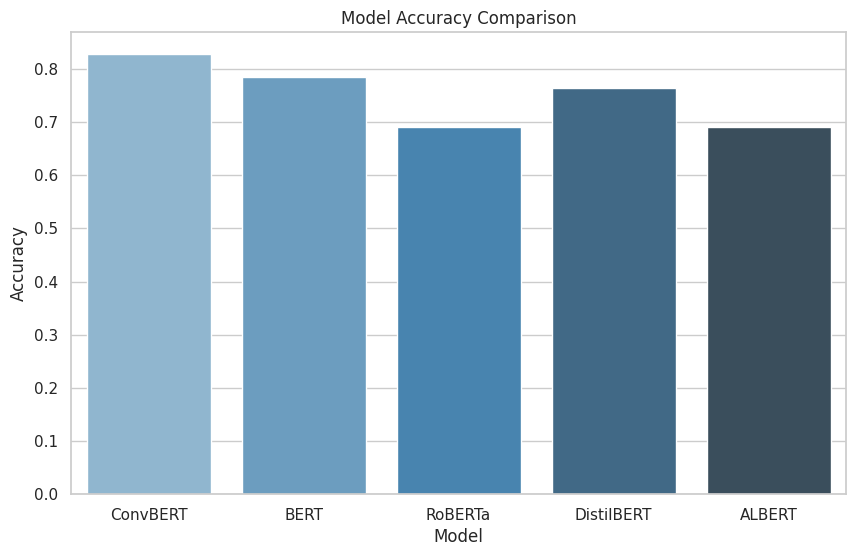

<ipython-input-9-6a9c0db6b11c>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=df, palette='Greens_d')


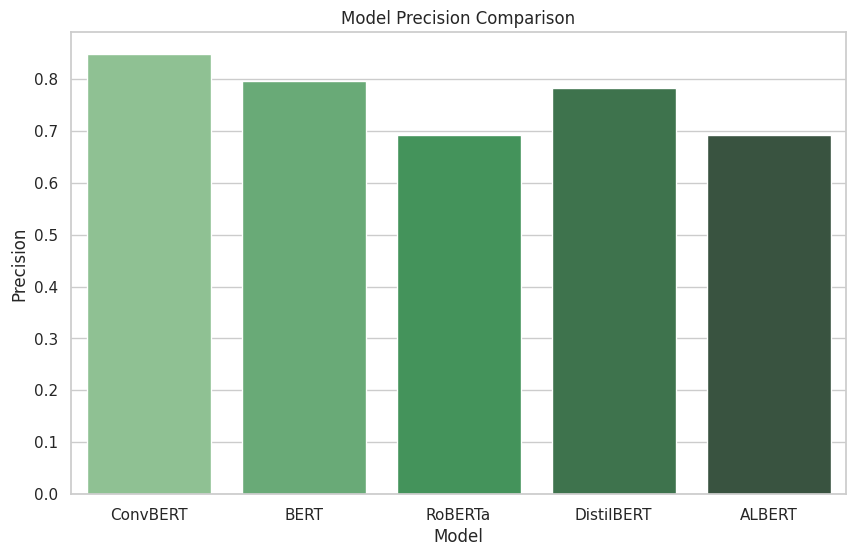

<ipython-input-9-6a9c0db6b11c>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=df, palette='Oranges_d')


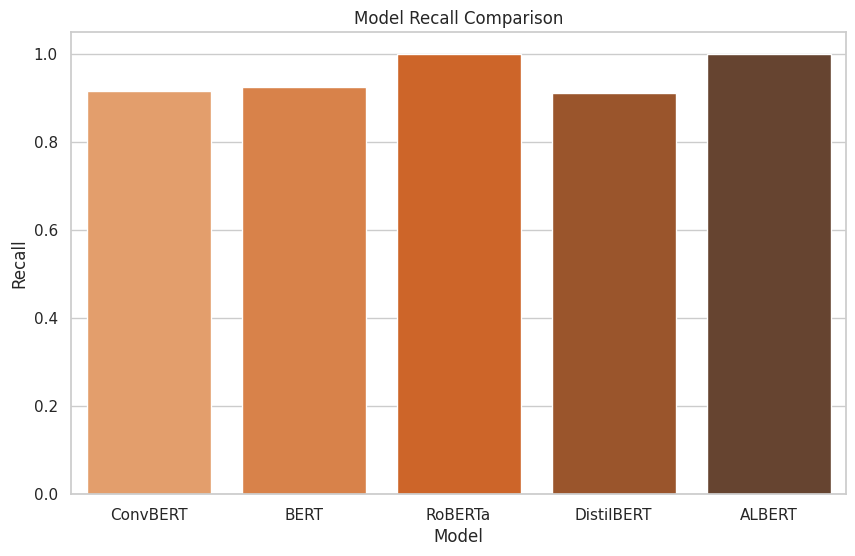

<ipython-input-9-6a9c0db6b11c>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-Score', data=df, palette='Reds_d')


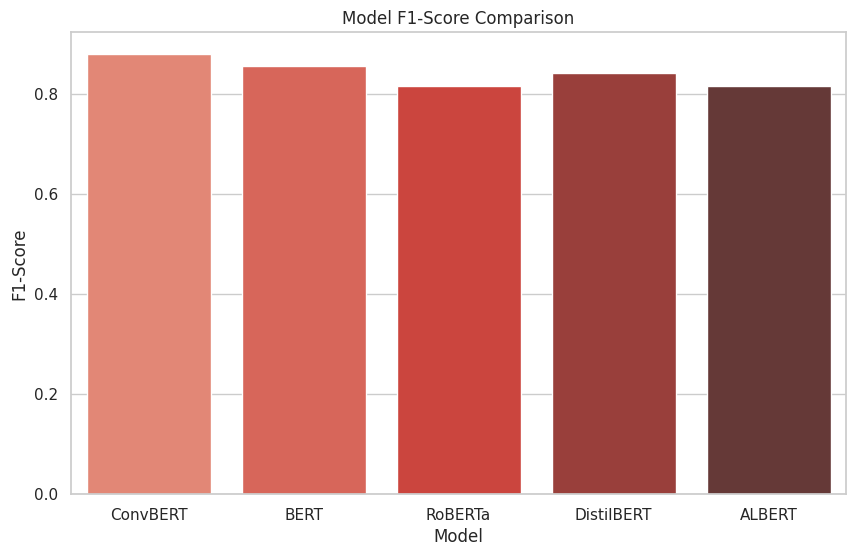

<ipython-input-9-6a9c0db6b11c>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time (s)', data=df, palette='Purples_d')


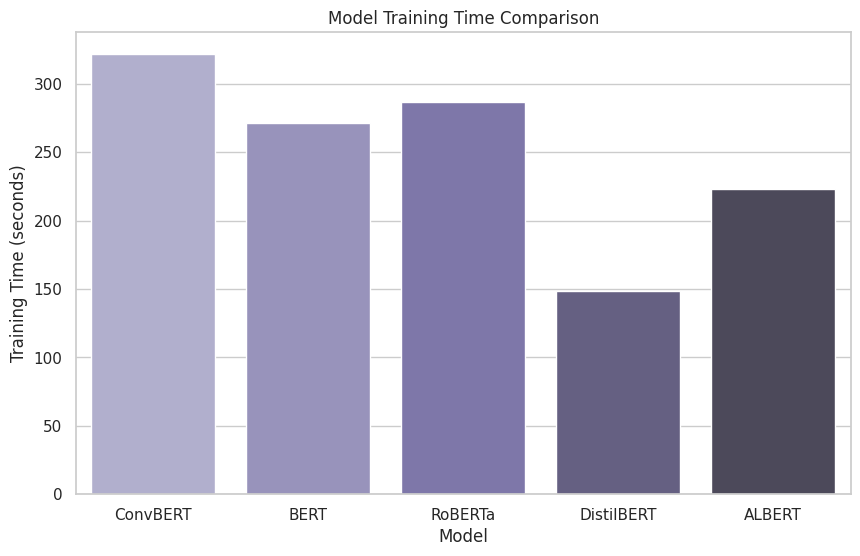

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Model Comparison Data
data = {
    'Model': ['ConvBERT', 'BERT', 'RoBERTa', 'DistilBERT', 'ALBERT'],
    'Accuracy': [0.8274, 0.7843, 0.6913, 0.7632, 0.6913],
    'Precision': [0.8472, 0.7959, 0.6913, 0.7815, 0.6913],
    'Recall': [0.9154, 0.9251, 1.0000, 0.9126, 1.0000],
    'F1-Score': [0.8800, 0.8557, 0.8175, 0.8420, 0.8175],
    'Training Time (s)': [321.66, 271.45, 286.56, 148.93, 222.94]
}

# Convert data to DataFrame for easier plotting
df = pd.DataFrame(data)

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Plot Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df, palette='Blues_d')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Precision', data=df, palette='Greens_d')
plt.title('Model Precision Comparison')
plt.ylabel('Precision')
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall', data=df, palette='Oranges_d')
plt.title('Model Recall Comparison')
plt.ylabel('Recall')
plt.show()

# Plot F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', data=df, palette='Reds_d')
plt.title('Model F1-Score Comparison')
plt.ylabel('F1-Score')
plt.show()

# Plot Training Time
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Time (s)', data=df, palette='Purples_d')
plt.title('Model Training Time Comparison')
plt.ylabel('Training Time (seconds)')
plt.show()
